# NLP Project Sentiment Analysis with BERT

## Setup

In [110]:
!pip install transformers --quiet
!pip install datasets --quiet
!pip install tensorflow --quiet 

In [121]:
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel
import os
from google.colab import drive
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification

In [ ]:
#Connect to google drive JULE SPECIFIC
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/NLP/Project/data/')

In [ ]:
# To use the data I import it as a pandas data frame
tweets_df = pd.read_csv('AAPL_pddf.csv')

## Explore the data

###Plots and Data

In [52]:
tweets_df.head(3)

,id,created_at,username,name,user_id,body,basic_sentiment,symbol0,symbol1,symbol2,symbol3,symbol4
0,410821194,2021-11-28 12:28:21+00:00,chuckygorman,Chuck Gorman,1068147,$AAPL $BA $DIS,0,AAPL,BA,DIS,NaN,NaN
1,410821004,2021-11-28 12:25:13+00:00,Renohawk,jessie livermore,162218,$SPY $TSLA $MRNA $AAPL $NVDA \n\nMy thoughts o...,0,AAPL,MRNA,NVDA,SPY,TSLA
2,410820720,2021-11-28 12:19:36+00:00,newtwo99,PS not a bot!,813188,$AAPL $BA $DIS $UNH,0,AAPL,BA,DIS,UNH,NaN


In [53]:
tweets_df.columns


Index(['id', 'created_at', 'username', 'name', 'user_id', 'body',
       'basic_sentiment', 'symbol0', 'symbol1', 'symbol2', 'symbol3',
       'symbol4'],
      dtype='object')

In [54]:
#Look at tweets
print(tweets_df['body'][3])

The industry average Profit Margin is 4.39%. $AAPL outperforms 93% of its industry peers. https://www.chartmill.com/stock/quote/AAPL/fundamental-analysis?key=bb853040-a4ac-41c6-b549-d218d2f21b32&amp;utm_source=stocktwits&amp;utm_medium=FA&amp;utm_content=AAPL&amp;utm_campaign=social_tracking


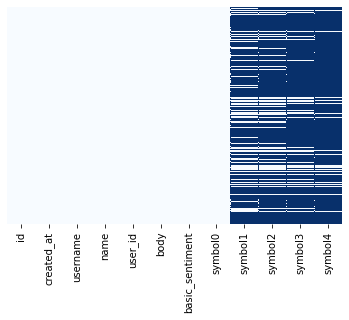

In [55]:
#check if there are any null elements: if there are white lines in the box there are null elements
import seaborn as sns
sns.heatmap(tweets_df.isnull(),yticklabels=False, cbar=False, cmap='Blues')
#results show: there are only white lines in features symbol1-symbol4 which we dont need anyways

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


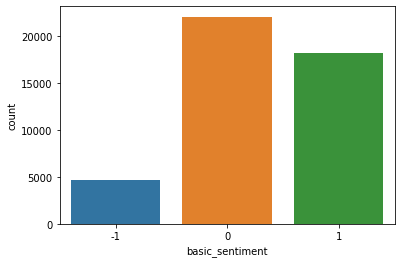

In [56]:
# Make a histogramm of the labels
sns.countplot(tweets_df['basic_sentiment'],label='Count')
#label imbalance
#stratified train test split (Verteilung beider labels sollte in splitted datasets das gleiche Verhältnis haben) sklearn function hat das
#when training the model there is a parameter "importance/weights" (tensor flow bei model.fit classweight oder sample_weigth)
#Bei evaluierung nicht accuracy wählen!  confusion matrix  anschauen (F1 score, F beta score, precision recall)

In [57]:
#Length of the tweets
#generate an additional column that contains the length of the tweets
tweets_df['length']=tweets_df['body'].apply(len)
tweets_df['length'].describe()

count    45000.000000
mean       106.986178
std        124.168693
min          5.000000
25%         35.000000
50%         69.000000
75%        133.000000
max       1599.000000
Name: length, dtype: float64

In [58]:
#shortest tweet
print(tweets_df[tweets_df['length']==5]['body'].iloc[0])
#longest tweet
print(tweets_df[tweets_df['length']==1599]['body'].iloc[0])

$AAPL
$MAT This round of NFT&#39;s for Hotwheels, the cost will be only $15 dollars... TONS wll be sold, it&#39;s not like last time where there was a biddin war for ONLY three unique Hotwheels, back in June. These will price for only 15 dollars. Tons are gonna be sold. And they each come with a REAL DIECAST VERSION. 
 NEW ARTICLE : Mattel Partners with WAX 
$WAX.X
 to Release Hot Wheels NFT Garage - Series 1 Out November 16th, in time for the Holidays. 
Official Website NFT/WAX HOTWHEEL SITE / Starts Nov 16th : (WITH WEBSITE COUNTDOWN CLOCK....)
https://wdny.io/hotwheels-s1/
https://www.businesswire.com/news/home/20211026006314/en/Mattel-Partners-with-WAX-to-Release-Hot-Wheels-NFT-Garage---Series-1/

Plus ONU Partnership Anounced TODAY with 
Mattel, Inc. (NASDAQ: MAT) is dropping the first-ever collaboration between UNO&amp;Nike, featuring a product line developed in coordination with the 2019-20 Kia NBA Most Valuable Player and UNO fan, Giannis Antetokounmpo. This press release featu

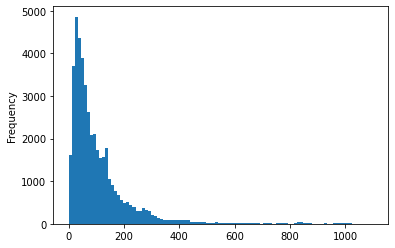

In [59]:
#histogramm of tweet length
tweets_df['length'].plot(bins=100,kind='hist',range = [0,1100])

###Create a WordCloud

In [60]:
#Postitive labels
positive = tweets_df[tweets_df['basic_sentiment']==-1]
negative = tweets_df[tweets_df['basic_sentiment']== 1]

#Turn all tweets into one string 
sentences = tweets_df['body'].tolist() #turns the tweet column into a list
len(sentences) # list has same length as number of tweets
sentences_as_one_string = "".join(sentences) # turns all sequences into one string

sentences_positive = positive['body'].tolist() #turns the tweet column into a list # list has same length as number of tweets
sentences_as_one_string_positive = "".join(sentences_positive) # turns all sequences into one string

sentences_negative = negative['body'].tolist() #turns the tweet column into a list # list has same length as number of tweets
sentences_as_one_string_negative = "".join(sentences_negative) # turns all sequences into one string


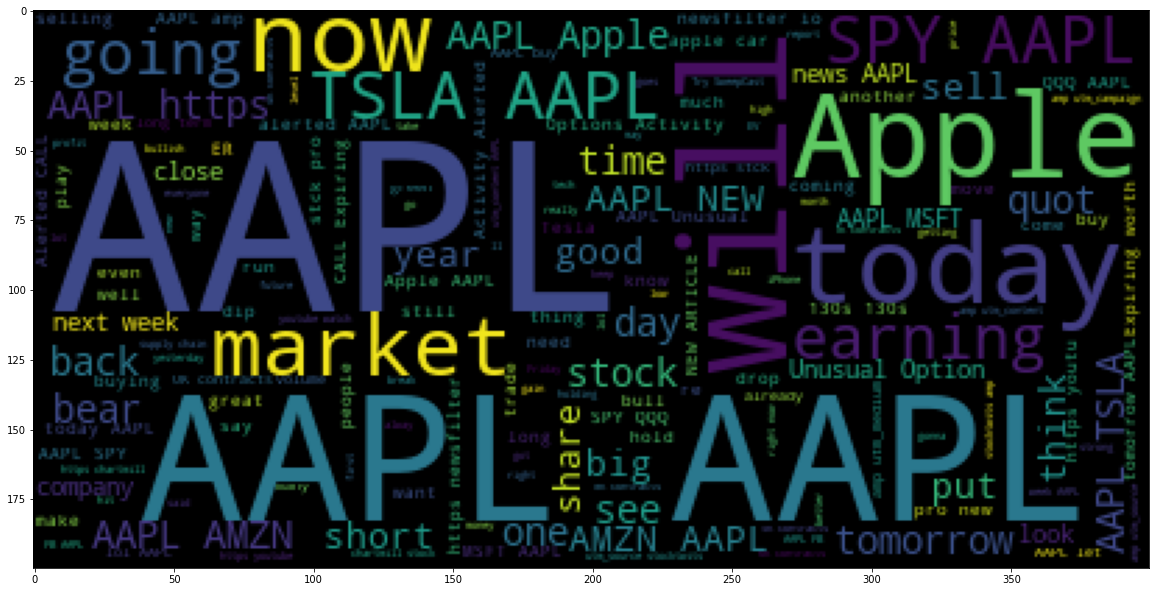

In [61]:
!pip install WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.figure(figsize =(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string))

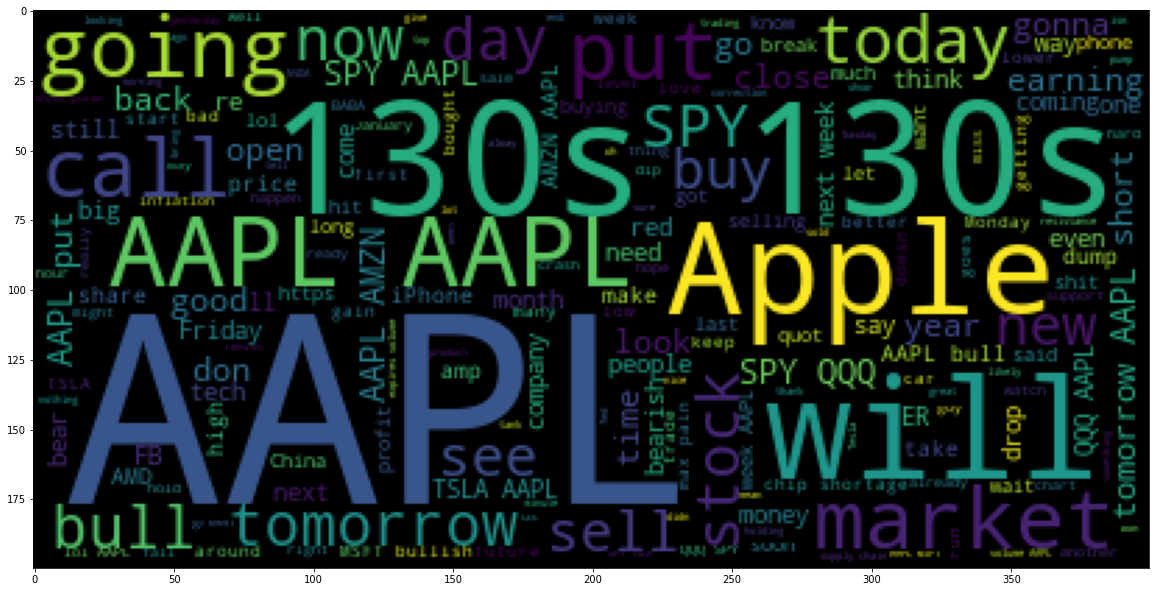

In [62]:
#postive WordCloud
plt.figure(figsize =(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string_positive))

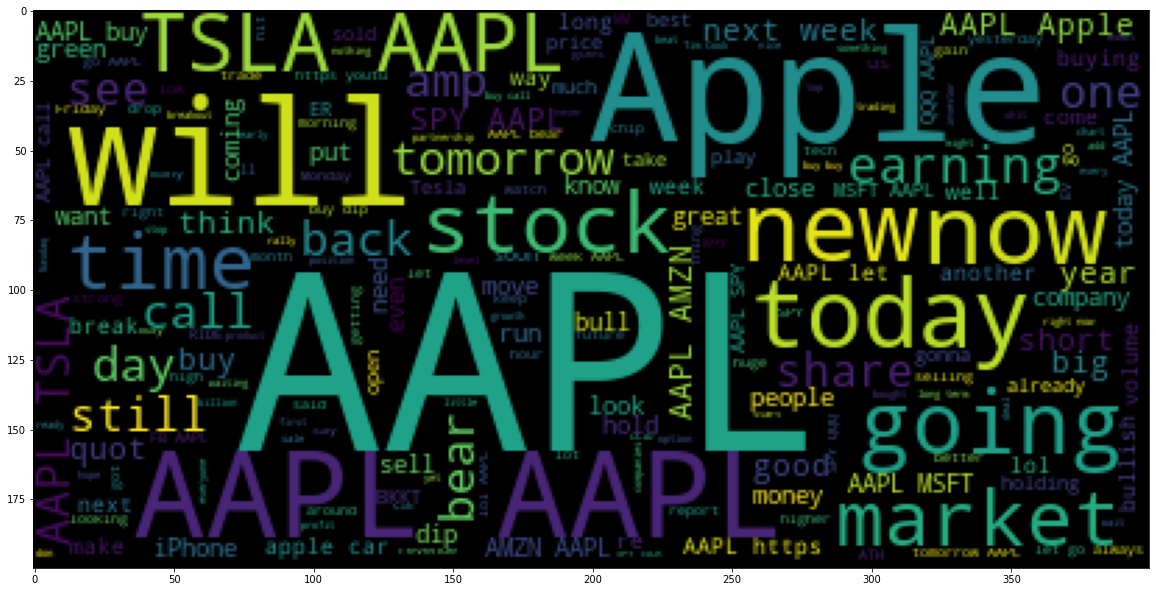

In [63]:
#negative WordCloud
plt.figure(figsize =(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string_negative))

## Data Preprocessing 
I delete all tweets where no sentiment was labeled (equal to basic sentiment = 0).
I further delete all columns except for body (which contains the tweet) and basic sentiment which corresponds to the label.

In [78]:
# save the dataset before modifying
df_labeled = tweets_df
df_labeled.head(2)

,id,created_at,username,name,user_id,body,basic_sentiment,symbol0,symbol1,symbol2,symbol3,symbol4,length
0,410821194,2021-11-28 12:28:21+00:00,chuckygorman,Chuck Gorman,1068147,$AAPL $BA $DIS,0,AAPL,BA,DIS,NaN,NaN,14
1,410821004,2021-11-28 12:25:13+00:00,Renohawk,jessie livermore,162218,$SPY $TSLA $MRNA $AAPL $NVDA \n\nMy thoughts o...,0,AAPL,MRNA,NVDA,SPY,TSLA,1019


In [79]:
# remove all unlabeled tweets (sentiment = 0) and all columns expect body and basic sentiment
df_labeled = tweets_df[tweets_df['basic_sentiment'] != 0]
df_labeled  = df_labeled[["body","basic_sentiment"]]
df_labeled.head(2)

,body,basic_sentiment
4,$AAPL $BA $DIS On the new Covid variant -\n\n&...,1
5,"Excellent, welcome to crash Monday and beyond ...",-1


In [96]:
# create huggingface/ arrow dataset from pandas df
dataset = Dataset.from_pandas(df_labeled).remove_columns("__index_level_0__")
dataset[0]

{'basic_sentiment': 1,
 'body': '$AAPL $BA $DIS On the new Covid variant -\n\n&quot;It presents mild disease with symptoms being sore muscles and tiredness for a day or two not feeling well,&quot; Coetzee explained. &quot;So far, we have detected that those infected do not suffer the loss of taste or smell. They might have a slight cough. There are no prominent symptoms. Of those infected some are currently being treated at home.&quot;'}

In [97]:
print("before: ",dataset.features)
# add labels to sentiment scores for better readability
# DOESN'T WORK -> labels 0,1,2 instead of -1,0,1
feat_sentiment = ClassLabel(names=["negative", "neutral", "positive"])
dataset = dataset.cast_column("basic_sentiment", feat_sentiment)
print("after: ", dataset.features)

before:  {'body': Value(dtype='string', id=None), 'basic_sentiment': Value(dtype='int64', id=None)}


Casting the dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

after:  {'body': Value(dtype='string', id=None), 'basic_sentiment': ClassLabel(num_classes=3, names=['negative', 'neutral', 'positive'], names_file=None, id=None)}


'positive'

In [113]:
#Split into training and test data
dataset_split = dataset_labeled.train_test_split(test_size=0.1) # to apply train_test_split I need to have a dataset not a datasetDict object 
train_data = dataset_split['train']
test_data = dataset_split['test']

#Split training data into training and validation data
train_data_split = train_data.train_test_split(test_size=1/9)
train_data = train_data_split['train']
validation_data = train_data_split['test']

train_test_validation_data = DatasetDict({
    'train': train_data,
    'validation': validation_data,
    'test': test_data
})

print(train_test_validation_data)
train_test_validation_data['train'].features
#problem: er sieht basic_sentiment als feature und int es ist aber ein binäres label

DatasetDict({
    train: Dataset({
        features: ['body', 'basic_sentiment'],
        num_rows: 18320
    })
    validation: Dataset({
        features: ['body', 'basic_sentiment'],
        num_rows: 2290
    })
    test: Dataset({
        features: ['body', 'basic_sentiment'],
        num_rows: 2290
    })
})


{'basic_sentiment': Value(dtype='int64', id=None),
 'body': Value(dtype='string', id=None)}

Tokenization

In [114]:
checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(dat):
  return tokenizer(dat["body"], truncation=True)

tokenized_dataset = train_test_validation_data.map(tokenize_function, batched = True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

#test
samples = tokenized_dataset['train'][:8]
samples={k:v for k,v in samples.items() if k not in
         ['body']}
#{len(x) for x in samples['input_ids']}
batch = data_collator(samples)
{k:v.shape for k,v in batch.items()}


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

{'attention_mask': TensorShape([8, 72]),
 'basic_sentiment': TensorShape([8]),
 'input_ids': TensorShape([8, 72]),
 'token_type_ids': TensorShape([8, 72])}

In [139]:
tf_train_dataset = tokenized_dataset['train'].to_tf_dataset(
    columns=["attention_mask","input_ids","token_type_ids", "basic_sentiment"],
    #label_cols= ["basic_sentiment"],
    shuffle = True,
    collate_fn = data_collator,
    batch_size = 8
)
tf_validation_dataset = tokenized_dataset['validation'].to_tf_dataset(
    columns=["attention_mask","input_ids","token_type_ids", "basic_sentiment"],
    #label_cols= ["basic_sentiment"],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = 8
)

Model Fine Tuning

In [123]:
# create model - since this is a bert model, it will use
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)
model

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [122]:
# define loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

# epoch, lr scheduler and optimizer
num_epochs = 3
num_train_steps = len(tf_train_dataset)*num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate = 5e-5, end_learning_rate = 0.0,
    decay_steps = num_train_steps)
opt = Adam(learning_rate = lr_scheduler)

model.compile(optimizer = opt, loss = loss, metrics = ["accuracy"])
# uses this fit function https://www.tensorflow.org/api_docs/python/tf/keras/Model
model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3
)

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
  34/2290 [..............................] - ETA: 4:36:53 - loss: 0.0876 - accuracy: 0.9926

KeyboardInterrupt: ignored

In [ ]:
print(output.logits.shape)
print(output.logits)

# turn output into predictions
predictions = tf.math.softmax(output.logits,axis=-1)
print(predictions)


(2, 2)
tf.Tensor(
[[-4.2659926  4.596534 ]
 [-2.2877994  2.361009 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1.415769e-04 9.998584e-01]
 [9.482228e-03 9.905178e-01]], shape=(2, 2), dtype=float32)
